In [19]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints
from RoutePlanner.Optimisation import TravelTime

def GreatCircle(Start_p,End_p):
    import pyproj
    import numpy as np
    startlong, startlat = Start_p
    endlong, endlat     = End_p
    startlong = startlong-360
    endlong   = endlong-360

    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                    1 + int(dist / 1000))

    lonlats = np.array(lonlats)
    lonlats[:,0] = lonlats[:,0]+360

    return lonlats

In [15]:
OptInfo = {}
OptInfo['Bounds Longitude']     = [230,360]
OptInfo['Bounds Latitude']      = [-80,-40]
OptInfo['Grid Spacing (dx,dy)'] = [5,2.5]
OptInfo['Start Time']           = '2017-05-01'
OptInfo['End Time']             = '2017-06-01'
OptInfo['WayPoints']            = pd.read_csv('../../resources/WayPoints_TestExample.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = True
OptInfo['VariableSpeed']        = False
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'
OptInfo['Start Waypoints']      = None

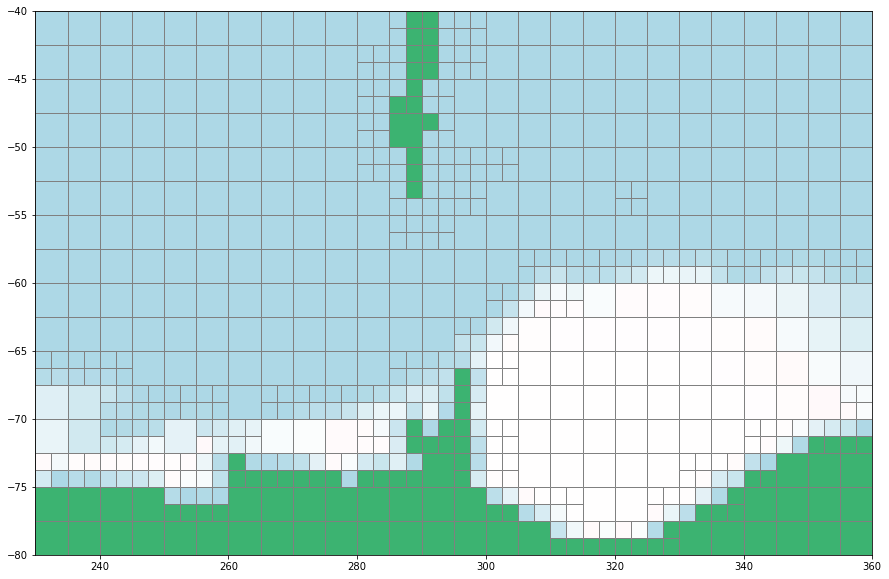

In [3]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(OptInfo)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(1)
cellGrid.plot()

In [4]:
TT = TravelTime(cellGrid)
TT.Dijkstra(verbrose=True)

=== Processing Waypoint = ArgentineSea ===
=== Processing Waypoint = MargueriteBay ===


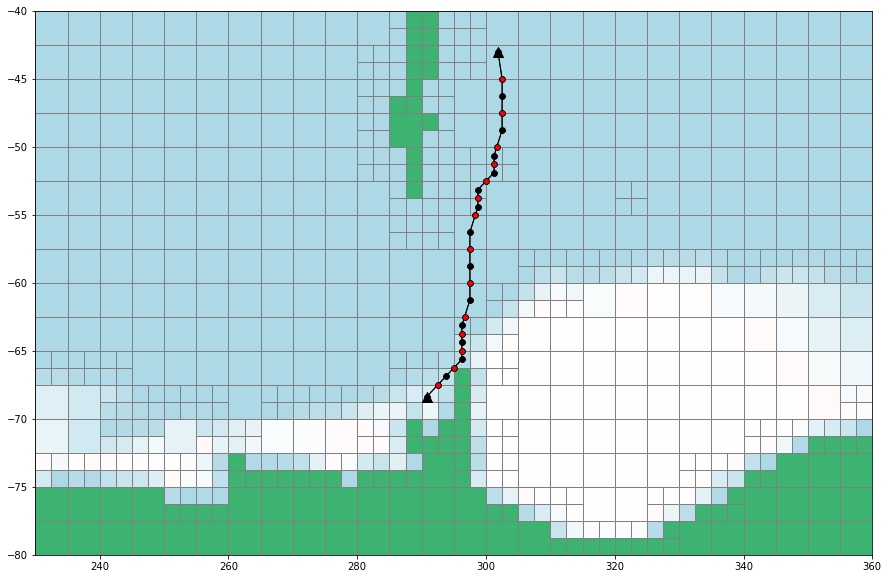

In [5]:
ax = TT.PlotPaths(routepoints=True)
Cps = TT.Paths[0]['Path']['CrossingPoints']
ax.scatter(Cps[:,0],Cps[:,1],15,'r',zorder=200)

In [6]:
TT.PathSmoothing(maxiter=500)

 PATH: ArgentineSea -> MargueriteBay 
 PATH: MargueriteBay -> ArgentineSea 


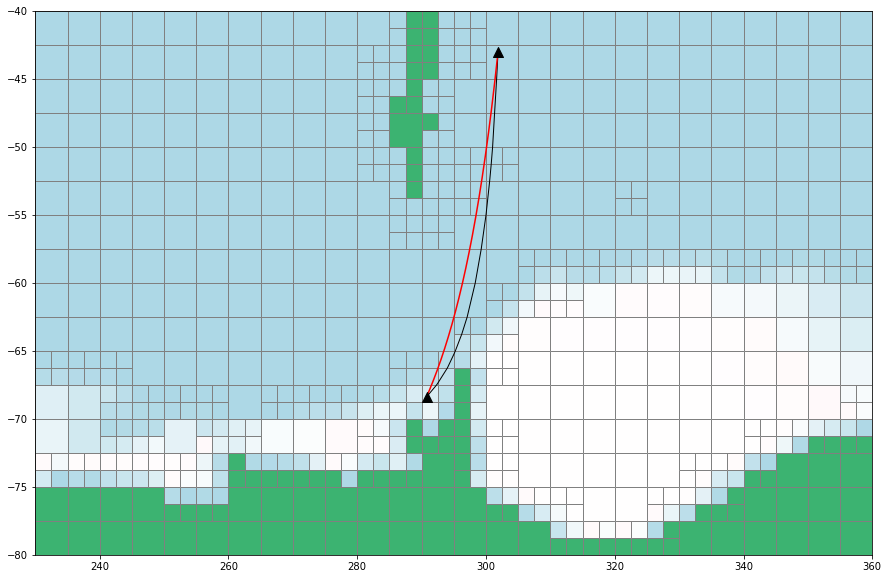

In [20]:
PATH1 =  TT.Paths[0]['Path']['FullPath']
ax = TT.PlotPaths(routepoints=False)
gc = GreatCircle((PATH1[0,0],PATH1[0,1]),(PATH1[-1,0],PATH1[-1,1]))
ax.plot(gc[:,0],gc[:,1],'r')

In [18]:
gc

array([[-58.13388889, -43.        ],
       [301.86412551, -43.00887666],
       [301.86213933, -43.01775326],
       ...,
       [290.77199235, -68.372197  ],
       [290.76419353, -68.38068202],
       [-69.24361111, -68.38916667]])

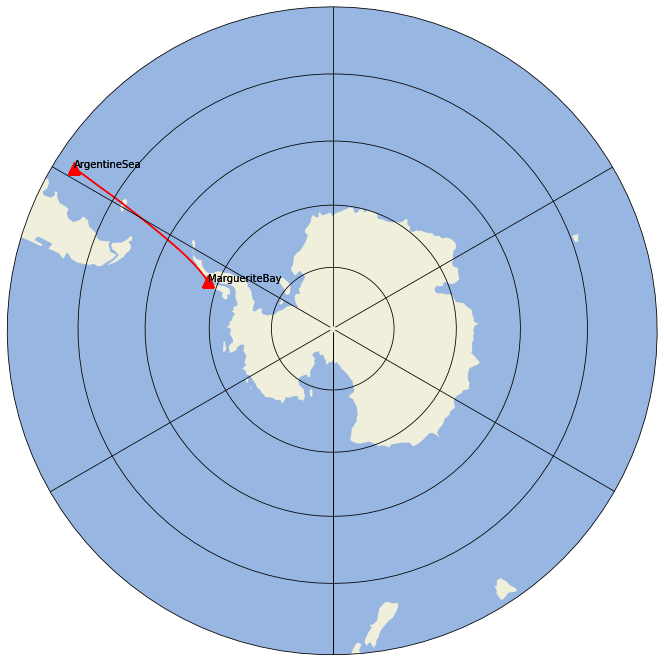

In [8]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature

PATH1 =  TT.Paths[0]['Path']['FullPath']

fig = plt.figure(figsize=[10, 10])
ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)
# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.OCEAN)
ax1.gridlines(color='k')


for ii in range(len(TT.Paths)):
    PATH1 =  TT.Paths[ii]['Path']['FullPath']

    ax1.plot(PATH1[:,0]-360,PATH1[:,1],'r',transform=ccrs.PlateCarree())
    for ii, wpt in OptInfo['WayPoints'].iterrows():
        ax1.scatter(wpt['Long']-360,wpt['Lat'],150,marker='^',color='r',transform=ccrs.PlateCarree())
        ax1.text(wpt['Long']-360,wpt['Lat'],wpt['Name'],transform=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)


In [9]:
pts = TT.Paths[0]['Path']['FullPath']
pts[:,0] = pts[:,0]-360

geoJSON = {}
geoJSON['type'] = "Feature"

geoJSON['geometry'] = {}
geoJSON['geometry']['type'] = "LineString"
geoJSON['geometry']['coordinates'] =TT.Paths[0]['Path']['FullPath'].tolist()

geoJSON['properties'] = {}
geoJSON['properties']['from'] = TT.Paths[0]['from']
geoJSON['properties']['to'] = TT.Paths[0]['to']
geoJSON['properties']['Travel Time (d)'] = TT.Paths[0]['TotalCost']

import json
with open('Path_MargueriteBay.json', 'w') as fp:
    json.dump(geoJSON, fp)

In [10]:
import pyproj


def GreatCircle(Start_p,End_p):
    startlong, startlat = Start_p
    endlong, endlat     = End_p
    startlong = startlong-360
    endlong   = endlong-360

    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                    1 + int(dist / 1000))

    # npts doesn't include start/end points, so prepend/append them
    lonlats.insert(0, (startlong, startlat))
    lonlats.append((endlong, endlat))

    lonlats = np.array(lonlats)

    return lonlats

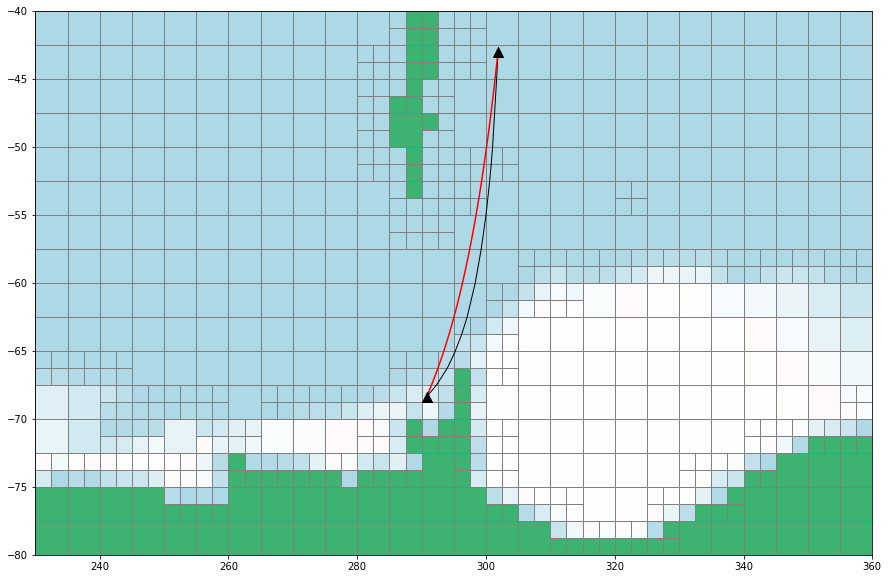

In [12]:
gc

array([[-69.24361111, -68.38916667],
       [-69.23580647, -68.38068202],
       [-69.22800765, -68.372197  ],
       ...,
       [-58.13786067, -43.01775326],
       [-58.13587449, -43.00887666],
       [-58.13388889, -43.        ]])